# Time Series Analysis on Fuel Prices in Spain

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
3. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
4. [Stationarity Testing](#stationarity-testing)
5. [Autocorrelation Analysis](#autocorrelation-analysis)
6. [Model Fitting](#model-fitting)
7. [Diagnostic Analysis](#diagnostic-analysis)
8. [Model Forecasting](#model-forecasting)
9. [Hyperparameter Optimization](#hyperparameter-optimization)
10. [Backtesting and Comparison](#backtesting-and-comparison)
11. [Conclusion](#conclusion)

## 1. Introduction
This report presents a time series analysis on monthly fuel prices in Spain, with the goal of understanding seasonal and trend patterns and building a predictive model for fuel prices. The data, analyzed in a univariate approach, includes gas prices, diesel prices, and light fuel oil prices, and focuses primarily on automotive diesel prices.

The analysis was conducted using a range of time series libraries, including `pmdarima`, `statsmodels`, and `skforecast`.

In [4]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import warnings
warnings.filterwarnings("ignore")

# Set options
pd.set_option('display.max_columns', None)
set_dark_theme()

The data come from IEA Monthly Oil Price Statistics, published by the International Energy Agency (IEA) and contains energy prices information.

The data is filtered to select records specific to Spain and priced in USD. It then pivots the table by product (e.g., fuel types), using the 'TIME' column as the index and the 'PRODUCT' column as the columns in the resulting DataFrame.

The index is set to a monthly frequency ('MS'), and the DataFrame is sorted by the index to ensure the data is in chronological order.

The percentage of rows with missing values is calculated to assess the quality of the data.

The code verifies whether the time index is continuous, meaning there are no missing dates between the earliest and latest available data.

Finally, the code converts the 'Light fuel oil' price data from per 1000 liters to per liter by dividing the values by 1000. 

These steps prepare the data for further analysis, ensuring that it is clean, correctly formatted, and free of missing values.

In [7]:
# Step 0: Load Data and Preprocess
data = pd.read_excel("../data/energy_prices_raw.xlsx")

# Filter for Spain and USD, then pivot by PRODUCT
pivoted_data = (
    data[
        (data['COUNTRY'] == 'Spain') &
        (data['UNIT'] == 'USD')
    ]
    .pivot_table(index='TIME', columns='PRODUCT', values='VALUE')
)

pivoted_data.columns.name = None  # Elimina el nombre del índice de columnas

# Set TIME as index and sort it
df = pivoted_data.asfreq('MS').sort_index()

# Missing values
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

# Verify that a temporary index is complete
start_date = df.index.min()
end_date = df.index.max()
date_range = pd.date_range(start=start_date, end=end_date, freq=df.index.freq)
is_index_complete = (df.index == date_range).all()
print(f"Index complete: {is_index_complete}")

# Convert Light Fuel Oil prices from per 1000 litres to per litre
df['Light fuel oil (unit/Litre)'] = df['Light fuel oil (unit/1000 litres)'] / 1000

Number of rows with missing values: 0.0
Index complete: True


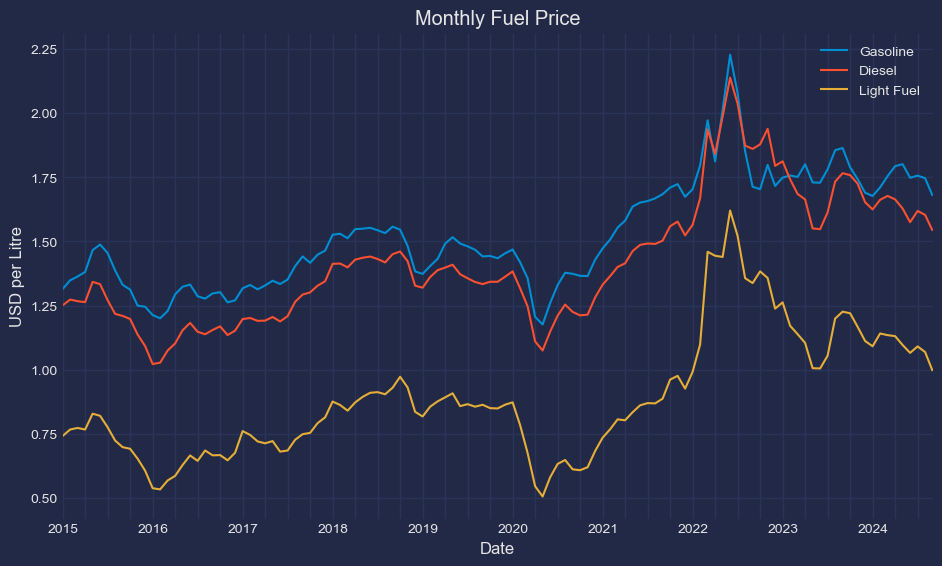

In [9]:
# Graphic representation of the Z_t
fig, ax = plt.subplots(figsize=(10, 6))
df['Gasoline (unit/Litre)'].plot(ax=ax, label='Gasoline')
df['Automotive diesel (unit/Litre)'].plot(ax=ax, label='Diesel')
df['Light fuel oil (unit/Litre)'].plot(ax=ax, label='Light Fuel')
plt.title('Monthly Fuel Price')
plt.xlabel('Date')
plt.ylabel('USD per Litre')
plt.legend()
plt.show()

# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is the initial step in understanding and analyzing time series data, particularly when studying price fluctuations, such as fuel prices. The main objective of EDA is to identify patterns, trends, and characteristics of the data that may affect modeling and forecasting. For time series analysis, the goal is to investigate the underlying structure of the data, which can be decomposed into various components, such as trend, seasonality, and randomness.

The plot displays the monthly fuel prices for three fuel types: Gasoline, Automotive Diesel, and Light Fuel Oil, from January 2015 to September 2024. Fuel prices are primarily determined by global crude oil prices, which have experienced notable fluctuations during the period from 2015 to 2024.
2015-2016: This period shows a significant drop in crude oil prices, largely due to a global oversupply, the slowdown in demand from major economies like China, and OPEC's strategy to maintain market share. This led to lower fuel prices worldwide.
2016-2018: Crude oil prices started to recover due to production cuts by OPEC and non-OPEC countries (including Russia). Global demand also increased, further supporting the upward trend in oil prices. The recovery in oil prices was mirrored by increases in fuel prices across all three fuel types. The recovery, while moderate, marked the beginning of more stable fuel prices after the volatility of 2015-2016.

2020: The outbreak of the COVID-19 pandemic in early 2020 caused a dramatic fall in global demand for fuel, leading to an unprecedented drop in oil prices in March 2020. In fact, oil futures briefly turned negative, reflecting the collapse in demand. Prices of gasoline, diesel, and light fuel oil plummeted during the early months of 2020. As demand for travel, industrial activity, and transportation dropped sharply, fuel prices saw significant reductions. However, prices started to rebound later in 2020 as economies began to reopen.

2021-2022:The recovery in global demand for fuel, combined with supply chain issues and geopolitical tensions (e.g., the Russia-Ukraine war starting in February 2022), led to significant increases in oil prices. Fuel prices surged during this period, driven by higher oil prices and disruptions in supply. This period saw significant price hikes for gasoline and diesel, with Light Fuel Oil also rising in response to increased heating oil demand during winter. Geopolitical tensions, particularly with Russia's invasion of Ukraine, caused further volatility.

2023-2024: Prices continued to experience fluctuations due to a combination of factors, including changes in global supply chains, inflationary pressures, and energy transitions. As countries increasingly focused on renewable energy and reducing reliance on fossil fuels, the price dynamics may have been impacted by these broader energy policy shifts.
The price fluctuations in 2023 and 2024 reflect a mix of recovering demand post-pandemic and ongoing geopolitical uncertainties.

## Timeserie Decomposition
Time series data, such as the diesel prices in Spain from 2015 to 2024, typically exhibits stochastic behavior, meaning that the future values depend on both deterministic and random factors. By examining the key components of the time series—trend, variance, seasonality, and randomness—we can gain insights into its structure.

Analyzing trend, variance, seasonality and random components.
¿Is variance constant?
¿Is mean constant?
¿Seasonality is present?

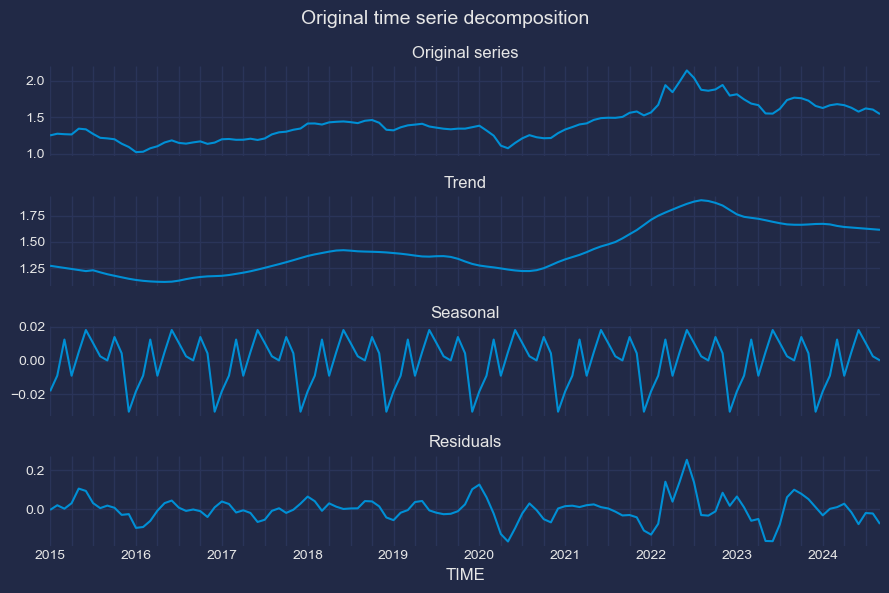

In [15]:
# Drop unnecessary columns for analysis
ts = df.drop(columns = ['Gasoline (unit/Litre)', 'Light fuel oil (unit/Litre)', 'Light fuel oil (unit/1000 litres)'])

# Original Time series Decomposition
res_decompose = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0])
axs[0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1])
axs[1].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2])
axs[2].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3])
axs[3].set_title('Residuals', fontsize=12)
fig.suptitle('Original time serie decomposition', fontsize=14)
fig.tight_layout()
plt.show()

The seasonal trend in diesel prices in Spain reveals several distinct patterns throughout the year.

The results, also, highlights a varying variance in the residuals, with lower variance from 2015–2020 and higher, more volatile variance afterward. This pattern suggests heteroscedasticity, which may impact the performance of an ARIMA model if left unaddressed. One common solution is to apply a log transformation (or sometimes a Box-Cox transformation) to stabilize the variance across the series. This transformation can help reduce the impact of extreme changes and make the series more suitable for ARIMA.

In [18]:
# Log transformation to stabilize the variance
ts['log_diesel']=np.log(ts['Automotive diesel (unit/Litre)'])

In [20]:
# Stationarity test (original and differenciated serie)
adfuller_result_ts = adfuller(ts['log_diesel'])
kpss_result_ts = kpss(ts['log_diesel'])

# First Differencing to achieve stationarity
ts_diff_1 = ts['log_diesel'].diff().dropna()

adfuller_result_ts1 = adfuller(ts_diff_1)
kpss_result_ts1 = kpss(ts['log_diesel'].diff().dropna())

print('Test stationarity for original series')
print('-------------------------------------')
print(f'ADF Statistic: {adfuller_result_ts[0]}, p-value: {adfuller_result_ts[1]}')
print(f'KPSS Statistic: {kpss_result_ts[0]}, p-value: {kpss_result_ts[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
print(f'ADF Statistic: {adfuller_result_ts1[0]}, p-value: {adfuller_result_ts1[1]}')
print(f'KPSS Statistic: {kpss_result_ts1[0]}, p-value: {kpss_result_ts1[1]}')

Test stationarity for original series
-------------------------------------
ADF Statistic: -1.443793018723801, p-value: 0.5611106031493612
KPSS Statistic: 1.201142158630331, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -7.2836809788327965, p-value: 1.4777631402539973e-10
KPSS Statistic: 0.07003074812878773, p-value: 0.1


In time series analysis, **stationarity** is a critical assumption, as many statistical methods, including ARIMA models, require the data to be stationary. A stationary series has properties that do not change over time, such as constant mean, variance, and autocovariance.

To address the stationarity of the series, two tests conducted: the **Augmented Dickey-Fuller (ADF) test** and the **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, both for the original and the differenced series.

The ADF and KPSS test results indicate that the original series is non-stationary (with high p-values for ADF and a low p-value for KPSS), but after first differencing, the series becomes stationary (ADF p-value is extremely low, and KPSS p-value is high). This suggests that a differencing order of 1 is appropriate for the ARIMA model.

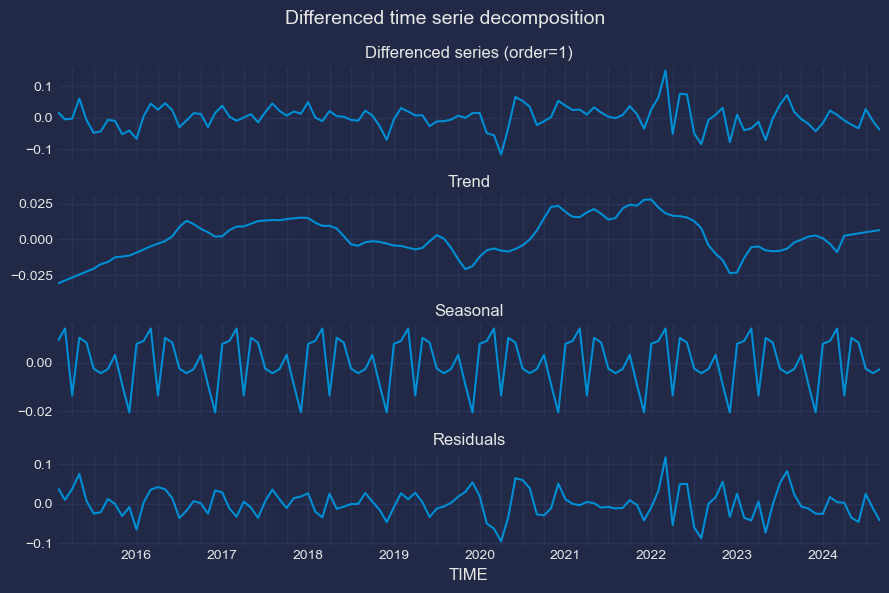

In [25]:
# Transformed and differenciate time serie decomposition to re-evaluate the stationarity tests 
# and variance to check if this has helped stabilize the residuals.
res_descompose_diff_1 = seasonal_decompose(ts_diff_1, model='additive', extrapolate_trend='freq')
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9, 6), sharex=True)
res_descompose_diff_1.observed.plot(ax=axs[0])
axs[0].set_title('Differenced series (order=1)', fontsize=12)
res_descompose_diff_1.trend.plot(ax=axs[1])
axs[1].set_title('Trend', fontsize=12)
res_descompose_diff_1.seasonal.plot(ax=axs[2])
axs[2].set_title('Seasonal', fontsize=12)
res_descompose_diff_1.resid.plot(ax=axs[3])
axs[3].set_title('Residuals', fontsize=12)
fig.suptitle('Differenced time serie decomposition', fontsize=14)
fig.tight_layout()
plt.show()

For the seasonal component, there is annual seasonality based on observation. Since the data is monthly, a seasonal period of 12 is reasonable. This leads to a SARIMA model (Seasonal ARIMA), where the seasonal parameters will capture the year-over-year effects.

# Autocorrelation analysis to etermine Parameters for SARIMA(p,d,q)(P,D,Q,s). 

Identify the appropriate SARIMA model components.

Autoregressive (AR): Identify the order of the autoregressive process by examining the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots.
Moving Average (MA): Identify the moving average order using the ACF plot.
Check for seasonality by inspecting seasonal plots or using tools like autocorrelation for seasonal lags.

In [ ]:
## ACF for original and differentiated series
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(ts['Automotive diesel (unit/Litre)'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(ts_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differentiated series (order=1)')
plt.show()

In [ ]:
## PACF for original and differenced series
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6,4), sharex = True)
plot_pacf(ts['Automotive diesel (unit/Litre)'], ax=axs[0], lags = 50,  alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(ts_diff_1, ax=axs[1], lags = 50, alpha =0.05)
axs[1].set_title('Partial autocorrelation diferenced serie (order = 1')
plt.show()

Based on ACF and PACF observations, the parameters for both the non-seasonal and seasonal parts of your SARIMA model are:

Non-Seasonal (p, d, q) Parameters:
Since the ACF and PACF both show a significant spike at lag 1 and then drop to zero, this suggests a simple structure for the non-seasonal AR and MA components:

AR (p) = 1: The spike in the PACF at lag 1 suggests a single autoregressive term.
MA (q) = 1: The spike in the ACF at lag 1 also suggests a single moving average term.
Differencing (d) = 1: Based on the stationarity test results, established before, a first difference (d = 1) is appropriate to make the series stationary.

Thus, for the non-seasonal component, ARIMA (p, d, q) = (1, 1, 1).

Seasonal (P, D, Q, s) Parameters:
With a monthly frequency and clear annual seasonality, the seasonal period s is 12.

From the PACF and ACF patterns following seasonal parameters are determined:

Seasonal AR (P) = 1: The significant spike at lag 12 in the PACF indicates that a seasonal autoregressive component of order 1 could be suitable.
Seasonal Differencing (D) = 1: Given the annual seasonality, D = 1 is typical to remove seasonal trends.
Seasonal MA (Q) = 1: Since the ACF shows a spike at lag 12, but below the confidence interval, Q=0 is considered.
For the seasonal part (P, D, Q, s) = (1, 1, 0, 12).

Based on these parameters, the SARIMA model would be:

**SARIMA(1, 1, 1)(1, 1, 1, 12)**

# SARIMA Model fitting 

In [ ]:
# Split Data into Train and Test
split_index = int(len(ts['log_diesel']) * 0.9)

data_train = ts['log_diesel'].iloc[:split_index]
data_test = ts['log_diesel'].iloc[split_index:]

print('\nTrain and Test Data range')
print('--------------------------------------------------')
print(
    f"Train dates : {ts.index.min()} --- {data_train.index.max()}  "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {ts.index.max()}  "
    f"(n={len(data_test)})"
)
# Plot train test
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(data_train.index, data_train.values, label='Train', color='blue')
ax.plot(data_test.index, data_test.values, label='Test', color='orange')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()
plt.show()

In [ ]:
# Fit SARIMA(1,1,1)(1,1,0,12) model
sarima_params = {
    'order': (1, 1, 0),       # (p, d, q)
    'seasonal_order': (0, 1, 1, 12)  # (P, D, Q, s)
}

# Initialize and fit SARIMA model
model = SARIMAX(data_train, order=sarima_params['order'], 
                seasonal_order=sarima_params['seasonal_order'])

original_model = model.fit(disp=False)

# Model summary
print(original_model.summary())

In [ ]:
# Diagnostic to evaluate model assumptions
original_model.plot_diagnostics(figsize=(10, 8))

Interpret Diagnostic

In [ ]:
# Predictions
predictions = original_model.get_forecast(steps=len(data_test))
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Plot predicted and observed data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data_train.index, data_train.values, label='Train data', color='blue')  # Train data in blue
ax.plot(data_test.index, data_test.values, label='Test data', color='orange')  # Test data in orange
ax.plot(data_test.index, predicted_mean, label='Predicted data', color='green')  # Predicted data in green

# Add confidence interval
ax.fill_between(data_test.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='grey', alpha=0.3)

ax.set_title('Monthly Fuel Consumption in Spain with Predictions')
ax.set_xlabel('Date')
ax.set_ylabel('Log Diesel Price')
ax.legend()
plt.show()

# Model tuning
Optimizing hyperparameters (p,d,q)(P,D,Q) using grid-search techniques and auto-arima.

In [ ]:
# Step 1: Split in train validation and test
end_train = '2022-02-01'
end_val = '2023-10-01'
print(
    f"\nTrain dates      : {ts.index.min()} --- {ts.loc[:end_train].index.max()}  "
    f"(n={len(ts.loc[:end_train])})"
)
print(
    f"Validation dates : {ts.loc[end_train:].index.min()} --- {ts.loc[:end_val].index.max()}  "
    f"(n={len(ts.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {ts.loc[end_val:].index.min()} --- {ts.index.max()}  "
    f"(n={len(ts.loc[end_val:])})"
)

# Plot train, validation and test
fig, ax = plt.subplots(figsize=(7, 3))
ts['log_diesel'].loc[:end_train].plot(ax=ax, label='train')
ts['log_diesel'].loc[end_train:end_val].plot(ax=ax, label='validation')
ts['log_diesel'].loc[end_val:].plot(ax=ax, label='test')
ax.set_title('Monthly fuel price in Spain')
ax.legend()
plt.show()

## Grid Search based on backtesting

In [ ]:
# Grid search based on backtesting
forecaster = ForecasterSarimax(
                 regressor = Sarimax(
                                order   = (1, 1, 1), # Placeholder replaced in the grid search
                                maxiter = 500
                             )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 12), (1, 1, 0, 12), (1, 1, 1, 12), (0, 1, 0, 12)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = ts['log_diesel'].loc[:end_val],
                   param_grid            = param_grid,
                   steps                 = 12,
                   refit                 = True,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(data_train),
                   fixed_train_size      = False,
                   return_best           = True,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )
print(results_grid[['order','seasonal_order', 'mean_absolute_error']].head(5))

## Auto-Arima

In [ ]:
# Auto arima: selection based on AIC
model = auto_arima(
            y                 = ts['log_diesel'].loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

## Predictions

In [ ]:
# Backtest predictions with the original model SARIMA(1,1,1)(1,1,0,12)
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1,1,1), seasonal_order=(1,1,0,12), maxiter=500),
    )
metric_m0, predictions_m0 = backtesting_sarimax(
    forecaster = forecaster, 
    y = ts['log_diesel'], 
    initial_train_size = len(ts['log_diesel'].loc[:end_val]),
    steps = 12, 
    metric = 'mean_absolute_error', 
    refit = True,
    n_jobs = "auto",
    suppress_warnings_fit = True,
    verbose               = False,
    show_progress         = True
    )

# Backtest predictions with the best model according to grid search
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(2, 1, 1), seasonal_order=(0, 1, 0, 12), maxiter=500),
             )

metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = ts['log_diesel'],
                                initial_train_size    = len(ts['log_diesel'].loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Backtest predictions with the best model according to auto-arima
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(0, 1, 0, 12), maxiter=500),
             )

metric_m2, predictions_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = ts['log_diesel'],
                                initial_train_size    = len(ts['log_diesel'].loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )


In [ ]:
# Compare predictions (MAE)
print("\nMEAN ABSOLUTE ERROR")
print("________________________________________________________________")
print("\nMetric (mean_absolute_error) for original model:")
print(metric_m0)
print("\nMetric (mean_absolute_error) for grid search model:")
print(metric_m1)
print("\nMetric (mean_absolute_error) for auto arima-model:")
print(metric_m2)

fig, ax = plt.subplots(figsize=(6, 3))

# Plot Actual data with Predictions
# =============================================================================
ts['log_diesel'].loc[end_val:].plot(ax=ax, label='test', color='grey')

predictions_m0 = predictions_m0.rename(columns={'pred': 'original model'})
predictions_m1 = predictions_m1.rename(columns={'pred': 'grid search'})
predictions_m2 = predictions_m2.rename(columns={'pred': 'autoarima'})

# Plot predictions
predictions_m0['original model'].plot(ax=ax, label='original model', color='orange', linestyle='--')
predictions_m1['grid search'].plot(ax=ax, label='grid search', color='green', linestyle='--')
predictions_m2['autoarima'].plot(ax=ax, label='autoarima', color='blue', linestyle='--')

ax.set_title('Backtest predictions with ARIMA model')
ax.legend()
plt.show()

# Conclusion and following steps